<a href="https://colab.research.google.com/github/venk221/SfM/blob/master/NeRF_ownShounak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import tqdm

import cv2

# For repeatability
# seed = 3407
# torch.manual_seed(seed)
# np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal length: 138.88887889922103
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Pose
[[ 6.8935126e-01  5.3373039e-01 -4.8982298e-01 -1.9745398e+00]
 [-7.2442728e-01  5.0788772e-01 -4.6610624e-01 -1.8789345e+00]
 [ 1.4901163e-08  6.7615211e-01  7.3676193e-01  2.9699826e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


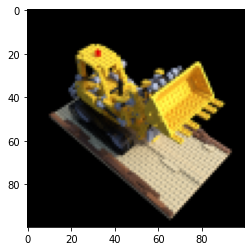

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

# print(f'Images shape: {type(images)}')
# print(f'Poses shape: {type(poses)}')

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')

height, width = images.shape[1:3]
near, far = 2., 6.   ### near and far used for calculating rays!

n_training = 100
testimg_idx = 101
testimg, testpose = images[testimg_idx], poses[testimg_idx]

print(type(testpose))
print(type(testimg))

plt.imshow(testimg)
print('Pose')
print(testpose)

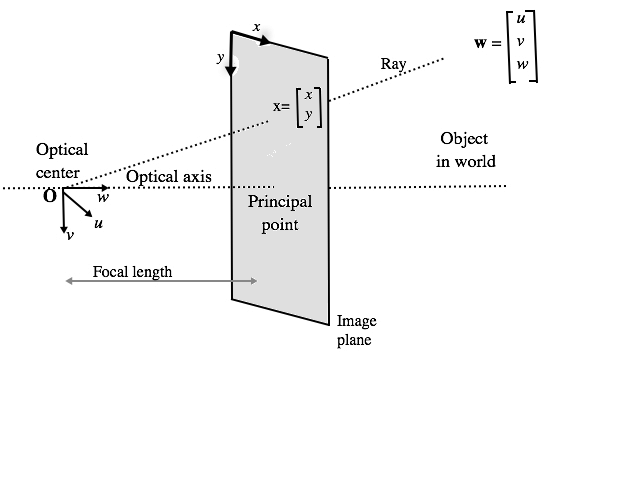

In [ ]:
def get_rays(height,width,focal_length,camera_pose):

  ### Here we assume a pinhole model. 
  #We know that the image height to the focal length ratio would be the same as the ratio between the object height and the distance between the optical center and object. 
  ## We use that fact to construct rays for each pixel in the image.

  x,y=torch.meshgrid(torch.arange(width, dtype=torch.float32).to(device),
      torch.arange(height, dtype=torch.float32).to(device))
  
  directions = torch.stack([(x - width * .5) / focal_length, #100*100 ## We subtract the 0.5*width from the x because we want to convert the image center to the optical axis.
                            -(y - height * .5) / focal_length, # 100*100
                            -torch.ones_like(x) #100*100 this is -1 because the z direction would always be -1
                           ], dim=-1)   ### This basically creates a tensor of 100*100*3

  # print(directions[0,0,None,:]*camera_pose[:3,:3])
  # print(torch.sum(directions[0,0,None,:]*camera_pose[:3,:3],dim=-1))

  rays_d = torch.sum(directions[..., None, :]*camera_pose[:3, :3],dim=-1) ## This gives us 100*100 [3] dimension rays.

  ### The above line is a element wise multiplication that projects the directions of the image plane onto the world plane. The sum allows the addition of all world x projections , all world y projections etc.
  ### Thus we get a world ray by the above operation

  rays_o= camera_pose[:3,-1].expand(rays_d.shape) ## The translation vector from the camera origin to world origin is the last column of pose. Expand makes the same vector repeat 100*100 times.


  return rays_o,rays_d




  

In [ ]:
images = torch.from_numpy(data['images'][:]).to(device)
poses = torch.from_numpy(data['poses']).to(device)
focal = torch.from_numpy(data['focal']).to(device)
testimg = torch.from_numpy(data['images'][testimg_idx]).to(device)
testpose = torch.from_numpy(data['poses'][testimg_idx]).to(device)

# Grab rays from sample image
height, width = images.shape[1:3]

ray_origin, ray_direction = get_rays(height, width, focal, testpose)

print('Ray Origin')
print(ray_origin.shape)
print(ray_origin[height // 2, width // 2, :])
print('')

print('Ray Direction')
print(ray_direction.shape)
print(ray_direction[height // 2, width // 2, :])
print('')

Ray Origin
torch.Size([100, 100, 3])
tensor([-1.9745, -1.8789,  2.9700])

Ray Direction
torch.Size([100, 100, 3])
tensor([ 0.4898,  0.4661, -0.7368])



/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
def sample_stratified(rays_o ,rays_d, near=2.0, far=6.0, n_samples=8):

  ray_points = torch.linspace(near, far, n_samples, device=rays_o.device)

  ##perturbed ray points
  temp_rand = torch.rand([n_samples], device=device)
  perturbed_ray_points=(near+(far-near)*temp_rand).sort().values


  perturbed_ray_points = perturbed_ray_points.expand(list([rays_o.shape[0]]) + [n_samples]) ### duplicates the perturbed points 10000 times
  # list(rays_o.shape[:-1]) + [n_samples] gives (10000,8)

  ### To get the actual points we use the following. PT=Origin+Direction*RayPoints(between 2 and 6)

  points=rays_o[:, None, :] + rays_d[:, None, :] * perturbed_ray_points[:, :, None]

  return points,perturbed_ray_points




In [ ]:
### Now we need to flatten the 100*100 into 10000 because that is how the input to the model looks like.

rays_o = ray_origin.view([-1, 3])
rays_d = ray_direction.view([-1, 3])
n_samples = 8

pts, perturbed_ray_points = sample_stratified(rays_o, rays_d, near, far)

print('Input Points')
print(pts.shape)
print('')
print('Distances Along Ray')
print(perturbed_ray_points.shape)

Input Points
torch.Size([10000, 8, 3])

Distances Along Ray
torch.Size([10000, 8])


In [ ]:
class PositionalEncoder(nn.Module):

  def __init__(self,input_dim,num_frequencies):

    super().__init__()
    self.num_frequencies=num_frequencies
    self.input_dim=input_dim
    self.output_dim=self.input_dim*(1+2*self.num_frequencies) ### 1 is because of the original flattened points, and for every freq_band there are 2 things to be appended thus 2*num_freq.
    ## this is to be done for 3 dimensions - x,y and z thus input_dim *()

    self.embed_tensor=[]

  def append_embed_tensors(self,x):

    self.embed_tensor.append(x)

    frequency_bands = 2.**torch.linspace(0., self.num_frequencies - 1, self.num_frequencies)

    for frequency in frequency_bands:
      self.embed_tensor.append(torch.sin(x*frequency))
      self.embed_tensor.append(torch.cos(x*frequency))



  def forward(self,x):

    self.append_embed_tensors(x)

    return_arr=self.embed_tensor
    self.embed_tensor=[]

    return torch.concat(return_arr, dim=-1)






In [ ]:
# Create encoders for points and view directions
encoder = PositionalEncoder(3, 10) ### encoder for x,y,z have 10 frequency component as per paper
viewdirs_encoder = PositionalEncoder(3, 4) ### encoder for theta , phi have 4 frequency components as per paper.

# Grab flattened points and view directions
pts_flattened = pts.reshape(-1, 3) ### converts pts from 10000,8,3 to 10000*8,3
viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
flattened_viewdirs = viewdirs[:, None, ...].expand(pts.shape).reshape((-1, 3))

# Encode inputs
encoded_points = encoder(pts_flattened)
print("b",encoded_points.shape)
encoded_viewdirs = viewdirs_encoder(flattened_viewdirs)
print("b",encoded_viewdirs.shape)
print('Encoded Points')
print(encoded_points.shape)
print(torch.min(encoded_points), torch.max(encoded_points), torch.mean(encoded_points))
print('')

print(encoded_viewdirs.shape)
print('Encoded Viewdirs')
print(torch.min(encoded_viewdirs), torch.max(encoded_viewdirs), torch.mean(encoded_viewdirs))
print('')

b torch.Size([80000, 63])
b torch.Size([80000, 27])
Encoded Points
torch.Size([80000, 63])
tensor(-2.3180) tensor(3.0536) tensor(0.0310)

torch.Size([80000, 27])
Encoded Viewdirs
tensor(-1.) tensor(1.) tensor(0.1698)



In [ ]:
class NeRF(nn.Module):
  r"""
  Neural radiance fields module.
  """
  def __init__(
    self,
    d_input: int = 3,
    n_layers: int = 8,
    d_filter: int = 256,
    skip: Tuple[int] = (4,),
    d_viewdirs: Optional[int] = None
  ):
    super().__init__()
    self.d_input = d_input
    self.skip = skip
    self.act = nn.functional.relu
    self.d_viewdirs = d_viewdirs

    # Create model layers
    self.layers = nn.ModuleList(
      [nn.Linear(self.d_input, d_filter)] +
      [nn.Linear(d_filter + self.d_input, d_filter) if i in skip \
       else nn.Linear(d_filter, d_filter) for i in range(n_layers - 1)]
    )

    # Bottleneck layers
    if self.d_viewdirs is not None:
      # If using viewdirs, split alpha and RGB
      self.alpha_out = nn.Linear(d_filter, 1)
      self.rgb_filters = nn.Linear(d_filter, d_filter)
      self.branch = nn.Linear(d_filter + self.d_viewdirs, d_filter // 2)
      self.output = nn.Linear(d_filter // 2, 3)
    else:
      # If no viewdirs, use simpler output
      self.output = nn.Linear(d_filter, 4)
  
  def forward(
    self,
    x: torch.Tensor,
    viewdirs: Optional[torch.Tensor] = None
  ) -> torch.Tensor:
    r"""
    Forward pass with optional view direction.
    """

    # Cannot use viewdirs if instantiated with d_viewdirs = None
    if self.d_viewdirs is None and viewdirs is not None:
      raise ValueError('Cannot input x_direction if d_viewdirs was not given.')

    # Apply forward pass up to bottleneck
    x_input = x
    for i, layer in enumerate(self.layers):
      x = self.act(layer(x))
      if i in self.skip:
        x = torch.cat([x, x_input], dim=-1)

    # Apply bottleneck
    if self.d_viewdirs is not None:
      # Split alpha from network output
      alpha = self.alpha_out(x)

      # Pass through bottleneck to get RGB
      x = self.rgb_filters(x)
      x = torch.concat([x, viewdirs], dim=-1)
      x = self.act(self.branch(x))
      x = self.output(x)

      # Concatenate alphas to output
      x = torch.concat([x, alpha], dim=-1)
    else:
      # Simple output
      x = self.output(x)
    return x

In [ ]:
# class NeRF(nn.Module):

#   def __init__(self,input_dim=3,num_layers=8,layer_dimension=256,skip=[],view_directions_dim=2):

#     super().__init__()
#     self.input_dim = input_dim
#     self.skip = skip
#     self.relu = nn.functional.relu
#     self.view_directions_dim = view_directions_dim

#     # Create model layers
#     self.fc_layers_256 = nn.ModuleList(
#       [nn.Linear(self.input_dim, layer_dimension)] +
#       [nn.Linear(layer_dimension + self.input_dim, layer_dimension) if i in skip \
#        else nn.Linear(layer_dimension, layer_dimension) for i in range(num_layers - 1)]
#     )

#     # self.fc_layers_256=nn.ModuleList(
#     #     [nn.Linear(self.input_dim, layer_dimension)] +                                      ### this is the input FC layer 3-->256
#     #     [nn.Linear(layer_dimension + self.input_dim, layer_dimension) if i in skip \  
#     #    else nn.Linear(layer_dimension, layer_dimension) for i in range(num_layers-1)]
#     # )

#     self.sigma=nn.Linear(layer_dimension,1)
#     self.add_layer = nn.Linear(layer_dimension, layer_dimension)
#     self.rgb_filter=nn.Linear(layer_dimension+self.view_directions_dim,layer_dimension/2)
#     self.rgb_output=nn.Linear(layer_dimension/2,3)   ###  This architechture can be found on page 18 of NeRF paper.

#     def forward(self,x,view_directions):


#       x_input = x

#       for i, layer in enumerate(self.fc_layers_256):

#         x = self.relu(layer(x))
#         if i in self.skip:
#           ### Since the next layer would have input 256+3
#           x = torch.cat([x, x_input], dim=-1)

#       x=self.add_layer(x) ## no activation

#       sigma = self.relu(self.sigma(x))  ### ReLU activation function for sigma value
#       x = torch.concat([x, view_directions], dim=-1)

#       x=self.relu(self.rgb_filter(x))
#       x=nn.functional.sigmoid(self.rgb_output(x)) #### Sigmoid activation function for RGB values.

#       x = torch.concat([x, sigma], dim=-1)


#       return x


In [ ]:
NeRF(3,8,256,[2],2)

NeRF(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=259, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=256, bias=True)
  )
  (alpha_out): Linear(in_features=256, out_features=1, bias=True)
  (rgb_filters): Linear(in_features=256, out_features=256, bias=True)
  (branch): Linear(in_features=258, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

 **Volume Rendering**

In [ ]:
def cumprod_exclusive(
  tensor):
  r"""
  (Courtesy of https://github.com/krrish94/nerf-pytorch)

  Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
  tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
    is to be computed.
  Returns:
  cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
    tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """

  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, -1)
  # "Roll" the elements along dimension 'dim' by 1 element. 
  cumprod = torch.roll(cumprod, 1, -1) #Basically shifting across columns that is the first element of a row is shifted to the next column in the same row. 
  ### shift by 1 and and dimension =-1 Basically the last column is shifted as the first and the first as second and similarluy
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1. #the first column which is the shifted last column is converted into ones.
  
  
  return cumprod

def raw2outputs(raw, perturbed_ray_points, rays_d):
  r"""
  Convert the raw NeRF output into RGB and other maps.
  This functions mimics the colour equation given on page 6 of the NeRF paper.
  """

  # Difference between consecutive elements of `perturbed_ray_points`. [n_rays, n_samples]
  dists = perturbed_ray_points[..., 1:] - perturbed_ray_points[..., :-1] # finds the difference between every consecutive points.
  dists = torch.cat([dists, 1e10 * torch.ones_like(dists[..., 1:2])], dim=-1) 
  #appending a column to the end (right) having all elements as 1e10 basically we are also equalling the dimensions.

  # print("distances",dists.shape)

  # Multiply each distance by the norm of its corresponding direction ray
  # to convert to real world distance (accounts for non-unit directions).
  magnitude = torch.norm(rays_d[..., None, :], dim=-1) #find the magnitude of the real world ray
  # print("magnitude", magnitude.shape)
  dists = dists * magnitude  #by multiplying the differences of sampled points from 2 to 6 and magnitude of rays, we get the real world distances.
  # print("after multi", dists.shape, dists)

  # Predict density of each sample along each ray. Higher values imply
  # higher likelihood of being absorbed at this point. [n_rays, n_samples]

  ##raw[...,3] is the sigma value that is it is the 4th element of the output of our model. 
  # according to the page number 6 of the NeRF paper, alpha value is given by:
  alpha = 1.0 - torch.exp(-raw[..., 3] * dists)

  # Compute weight for RGB of each sample along each ray. [n_rays, n_samples]
  # The higher the alpha, the lower subsequent weights are driven.
  Ti = cumprod_exclusive((torch.exp(-raw[..., 3] * dists) + 1e-10))  #added an epsilon value for numerical stability during backprop
  # print("raw*dists",(torch.exp(-raw[..., 3] * dists)))
  # print("before cumproduct", (torch.exp(-raw[..., 3] * dists)) + 1e-10 )
  weights = alpha * Ti #according to the paper, the weights are given by the multiplication of cumulative product times the alpha 
  # print("weights", weights.shape)
  # print("RGB value from the model", raw[..., :3].shape)

  
  # Compute weighted RGB map.
  # [n_rays, n_samples, 3]
  rgb_map = torch.sum(weights[..., None] * raw[..., :3], dim=-2)  
  """ [n_rays, 3] , rgb = raw[..., :3], dim = -2 means the -2 dimension is reduced and the output becomes 10,000 by 3. """
  # print("RGBmap",rgb_map.shape)
  return rgb_map, weights

**Computational Effectiveness Code**

In [ ]:
def get_chunks(inputs, chunksize ):

  # print(inputs.shape)
  # print(chunksize)

  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)] ## stepsize for range is chunksize. Basically we make "batches" from the input as well.


def prepare_chunks(points,positional_encoding,chunksize):

  
  points=points.reshape((-1,3)) ## flattens all points but we still have x,y and z coordinates.

  # print(points.shape)
  encoded_pts=positional_encoding(points)

  chunk_points=get_chunks(encoded_pts,chunksize)

  

  return chunk_points


def directional_chunks_fn(points,directional_rays,directional_encoding,chunksize):

  ### First normalize the directions ####
  directional_rays=directional_rays / torch.norm(directional_rays, dim=-1, keepdim=True)  ## keepdim is kept True to ensure the shape number is kept the same

  directional_rays=directional_rays[:, None, ...].expand(points.shape).reshape((-1, 3))   ### This is done to make the shape of the directional rays to be equal to the shape of the points flattened which is 80k,3

  ###  directional_rays[:, None, ...] adds a empty dimension in the middle making it 10k,1,3 from 10k,3
  #### expand(points.shape) copies the 10k vectors 8 times making it 10k,8,3
  #### Now we flatten the 10k,8,3 to make it 80k,3 . 80k,3 is the shape of the points flattened.


  directional_rays = directional_encoding(directional_rays)
  directional_rays = get_chunks(directional_rays, chunksize=chunksize)

  return directional_rays


In [ ]:
def nerf_forward(rays_origin,rays_direction,near,far,model,positional_encoding,directional_encoding,chunksize,n_samples):
  r"""
  Compute forward pass through coarse model.
  """


  ## Sampling points on each ray
  pts, perturbed_ray_points = sample_stratified(rays_origin,rays_direction, near, far,n_samples)

  

  ## Prepare chunks for computation
  positional_chunks = prepare_chunks(pts, positional_encoding,chunksize)
  print(positional_chunks[-1].shape)
  directional_chunks = directional_chunks_fn(pts,rays_d,directional_encoding,chunksize)

  

  ## Forward pass ##

  model_outputs=[]

  for ps_chunk, dr_chunk in zip(positional_chunks,directional_chunks):

    model_outputs.append(model(ps_chunk,dr_chunk))

  model_outputs = torch.cat(model_outputs,dim=0) ### This clubs all model outputs across chunks together. The shape at this point would be 64k,4

  model_outputs = model_outputs.reshape(list(pts.shape[:2]) + [model_outputs.shape[-1]])  ## This basically reshapes 64k,4 into 10000,64,4

  rgb_map, weights = raw2outputs(model_outputs, perturbed_ray_points, rays_d)

  output_dict={}
  output_dict['rgb_map'] = rgb_map
  output_dict['weights'] = weights

  return output_dict






**Hyperparameters for the given Run**

In [ ]:
# Encoders
input_dim = 3                         # Number of input dimensions   ###Both the position and view are described as a 3 dimensional vector. 
positional_frequencies = 10          # Number of encoding functions for samples
view_frequencies = 4                  # Number of encoding functions for views

# Stratified sampling
num_samples = 64         # Number of spatial samples per ray

# Model
layer_dimension = 128         # Dimensions of linear layer filters
num_layers = 4            # Number of layers in network bottleneck
skip = [2]               # Layers at which to apply input residual

# Optimizer
lr = 5e-4                 # Learning rate

# Training
iterations = 100
chunksize = 2**8          # Modify as needed to fit in GPU memory
eval_rate = 4          # Display test output every X epochs


**Initializing all models and variables**

In [ ]:
## Positional encoder
encoder = PositionalEncoder(input_dim, positional_frequencies)


## Directional encoder  
encoder_viewdirs = PositionalEncoder(input_dim, view_frequencies)


### Initilaize NeRF model and put it into GPU.

#(self,input_dim=3,num_layers=8,layer_dimension=256,skip=[],view_directions_dim=2)
model = NeRF(encoder.output_dim,num_layers,layer_dimension,skip,encoder_viewdirs.output_dim)
model.to(device)

optimizer = torch.optim.Adam(list(model.parameters()), lr=lr)







In [ ]:
def training_loop():
  r"""
  Launch training session for NeRF.
  """

  ## We use 1 image per iteration

  model.train()


  train_loss_li=[]
  val_loss_li=[]

  for iteration_number in tqdm(range(iterations),total=iterations):

    ########## Get a random image between the first 100 images ########
    image_index = np.random.randint(images[:100].shape[0])
    image = images[image_index].to(device)

    height, width = image.shape[:2]

    ### Get the pose ###
    pose = poses[image_index].to(device)

    ####### Get rays ######
    ray_origin, ray_direction = get_rays(height, width, focal, pose)

    ray_origin=ray_origin.reshape([-1,3])
    ray_direction=ray_direction.reshape([-1,3])   ### Reshaping has to be done so that we can stratify these rays.

    #nerf_forward(rays_origin,rays_direction,near,far,model,positional_encoding,directional_encoding,chunksize,n_samples):
    outputs = nerf_forward(ray_origin, ray_direction,near, far, model, encoder, encoder_viewdirs,chunksize, num_samples)

    ### Compute loss and do backprop #####

    predicted_img = outputs['rgb_map']
    print(predicted_img)
    loss = torch.nn.functional.mse_loss(predicted_img, image.reshape([-1,3]))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # print("Loss",loss.item())

    train_loss_li.append(-10*torch.log10(loss).item())   ### Take the log with the base 10 of the loss.



    ############ Validation loop ####################

    if (iteration_number+1)%eval_rate==0:

      ## Putting model into eval mode ###
      model.eval()

      height, width = testimg.shape[:2]
      ray_origin, ray_direction = get_rays(height, width, focal, pose)

      ray_origin = ray_origin.reshape([-1, 3])
      ray_direction = ray_direction.reshape([-1, 3])

      outputs = nerf_forward(ray_origin, ray_direction,near, far, model, encoder, encoder_viewdirs,chunksize, num_samples)

      predicted_img=outputs['rgb_map']
      val_loss= torch.nn.functional.mse_loss(predicted_img, testimg.reshape([-1,3]))

      val_loss_item=val_loss.item()

      print(f'Validation loss at iteration {iteration_number} is {val_loss_item}')

    
      val_loss_li.append(-10*torch.log10(val_loss).item())


      ############## Draw figure of predicted image and ground truth image. ################
      fig, ax = plt.subplots(1, 2, figsize=(8,4))

      ax[0].imshow(predicted_img.reshape([height, width, 3]).detach().cpu().numpy())
      ax[0].set_title(f'Iteration: {iteration_number}')

      ax[1].imshow(testimg.detach().cpu().numpy())
      ax[1].set_title('Target')

      plt.show()


  torch.save(model.state_dict(), 'saved_model.pth')


  return train_loss_li,val_loss_li



  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([256, 63])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<SumBackward1>)


  1%|          | 1/100 [00:10<17:24, 10.55s/it]

torch.Size([256, 63])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<SumBackward1>)


  2%|▏         | 2/100 [00:21<17:20, 10.62s/it]

torch.Size([256, 63])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<SumBackward1>)


  3%|▎         | 3/100 [00:30<16:28, 10.19s/it]

torch.Size([256, 63])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<SumBackward1>)
torch.Size([256, 63])
Validation loss at iteration 3 is nan


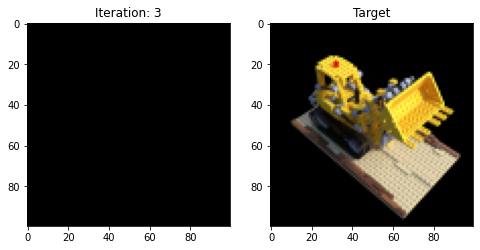

  4%|▍         | 4/100 [00:44<18:37, 11.64s/it]

torch.Size([256, 63])
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<SumBackward1>)


  4%|▍         | 4/100 [00:54<21:56, 13.72s/it]


KeyboardInterrupt: ignored

In [ ]:
train_loss_li,val_loss_li = training_loop()

**Video Generation**

In [ ]:
### Take the last 5 images ###
### Calculate rays ####
### Model output ####


height, width = images.shape[1:3]

# fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# video=cv2.VideoWriter('./video.mp4',fourcc,1,(width,height))

for i in [102,103,104,105]:

  target_img = images[i].to(device)
  target_pose = poses[i].to(device)

  height, width = target_img.shape[:2]


  rays_o, rays_d = get_rays(height, width, focal, target_pose)
  rays_o = rays_o.reshape([-1, 3])
  rays_d = rays_d.reshape([-1, 3])

  outputs = nerf_forward(rays_o, rays_d,
                           near, far, encoder, model,
                           viewdirs_encoding_fn=encode_viewdirs,
                           chunksize=chunksize)
  
  rgb_predicted = outputs['rgb_map']

  rgb_predicted=rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy()



  rgb_predicted_frame=cv2.cvtColor(rgb_predicted, cv2.COLOR_RGB2BGR)

  
  
  plt.imshow(rgb_predicted)
  plt.show()



del model
